## Imports ##

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import pandas as pd
import pickle
import numpy as np

#### Datasets

In [2]:
x_train_cell_lines = pd.read_csv('data/splits/train/x_train_cell_lines.csv', index_col=0)
x_train_drugs = pd.read_csv('data/splits/train/x_train_drugs.csv', index_col=0)
y_train = pd.read_csv('data/splits/train/y_train.csv', index_col=0)

x_test_cell_lines = pd.read_csv('data/splits/test/x_test_cell_lines.csv', index_col=0)
x_test_drugs = pd.read_csv('data/splits/test/x_test_drugs.csv', index_col=0)
y_test = pd.read_csv('data/splits/test/y_test.csv', index_col=0)

x_val_cell_lines = pd.read_csv('data/splits/val/x_val_cell_lines.csv', index_col=0)
x_val_drugs = pd.read_csv('data/splits/val/x_val_drugs.csv', index_col=0)
y_val = pd.read_csv('data/splits/val/y_val.csv', index_col=0)

In [3]:
x_train_drugs

,Drug
Dabrafenib_SW1710,CC(C)(C)C1=NC(=C(S1)C2=NC(=NC=C2)N)C3=C(C(=CC=...
Lapatinib_TGW,CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3...
Ruxolitinib_GCT,C1CCC(C1)[C@@H](CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
MN-64_EW-24,CC(C)C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2
Sapitinib_NCI-H1869,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...
...,...
PFI3_SW1463,C1[C@@H]2CN([C@H]1CN2C3=CC=CC=N3)/C=C/C(=O)C4=...
I-BRD9_SW1710,CCN1C=C(C2=C(C1=O)C=C(S2)C(=NC3CCS(=O)(=O)CC3)...
Olaparib_RERF-GC-1B,C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC...
Crizotinib_HCC2218,C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=...


### Merge data

In [4]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

x_train_drugs['Drug'] = x_train_drugs['Drug'].apply(smiles_to_fingerprint)
x_test_drugs['Drug'] = x_test_drugs['Drug'].apply(smiles_to_fingerprint)
x_val_drugs['Drug'] = x_val_drugs['Drug'].apply(smiles_to_fingerprint)

In [5]:
x_train_drugs

,Drug
Dabrafenib_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
Lapatinib_TGW,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
Ruxolitinib_GCT,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
MN-64_EW-24,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Sapitinib_NCI-H1869,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
PFI3_SW1463,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
I-BRD9_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Olaparib_RERF-GC-1B,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Crizotinib_HCC2218,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
x_train_drugs = pd.concat([x_train_drugs.drop(['Drug'], axis=1), x_train_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_test_drugs = pd.concat([x_test_drugs.drop(['Drug'], axis=1), x_test_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_val_drugs = pd.concat([x_val_drugs.drop(['Drug'], axis=1), x_val_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)

In [7]:
x_train_drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Dabrafenib_SW1710,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
Lapatinib_TGW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ruxolitinib_GCT,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
MN-64_EW-24,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sapitinib_NCI-H1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PFI3_SW1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
I-BRD9_SW1710,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
Olaparib_RERF-GC-1B,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Crizotinib_HCC2218,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

# Machine learning Models

In [9]:
# merge drug and cell lines
x_train = pd.concat([x_train_cell_lines, x_train_drugs], axis=1)
x_test = pd.concat([x_test_cell_lines, x_test_drugs], axis=1)
x_val = pd.concat([x_val_cell_lines, x_val_drugs], axis=1)


### linear

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True, positive=False)
lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('MSE: ', mean_squared_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('R2: ', r2_score(y_test, y_pred_lr))







Linear Regression
MAE:  0.8845281548951429
MSE:  1.4137157356447514
RMSE:  1.1889977862236545
R2:  0.8137075172310488


In [11]:
# grid search with linear regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


param_grid = {'fit_intercept':[True,False]}


grid = GridSearchCV(LinearRegression() ,param_grid, cv=5, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ................fit_intercept=True;, score=0.811 total time=  36.1s
[CV 2/5] END ................fit_intercept=True;, score=0.816 total time=  35.2s
[CV 3/5] END ................fit_intercept=True;, score=0.805 total time=  34.4s
[CV 4/5] END ................fit_intercept=True;, score=0.817 total time=  35.0s
[CV 5/5] END ................fit_intercept=True;, score=0.802 total time=  34.6s
[CV 1/5] END ...............fit_intercept=False;, score=0.811 total time=  34.8s
[CV 2/5] END ...............fit_intercept=False;, score=0.816 total time=  36.9s
[CV 3/5] END ...............fit_intercept=False;, score=0.806 total time=  34.5s
[CV 4/5] END ...............fit_intercept=False;, score=0.818 total time=  39.2s
[CV 5/5] END ...............fit_intercept=False;, score=0.803 total time=  34.4s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, verbose=3)

In [17]:
# summarize the results of the grid search
print("Best Score: {}".format(grid.best_score_))
print("Best params: {}".format(grid.best_params_))

# store best model in a variable
best_model = grid.best_estimator_

# store best model in pickle file
pickle.dump(best_model, open('trained_models/linear_regression.pkl', 'wb'))

# predict using best model
y_pred = best_model.predict(x_test)

# evaluate predictions
print('Linear Regression')
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2: ', r2_score(y_test, y_pred))






Best Score: 0.8109710874366348
Best params: {'fit_intercept': False}
Linear Regression
MAE:  0.8821509833742792
MSE:  1.4018256770864501
RMSE:  1.1839871946463145
R2:  0.8152743304688488


### Gradient Boosting Regressor

In [13]:
#histogram based gradient boosting regressor
from sklearn.ensemble import HistGradientBoostingRegressor

hist = HistGradientBoostingRegressor()
hist.fit(x_train, y_train)
y_pred_gbr = hist.predict(x_test)
print('Histogram Based Gradient Boosting Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_gbr))
print('MSE: ', mean_squared_error(y_test, y_pred_gbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print('R2: ', r2_score(y_test, y_pred_gbr))




c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Histogram Based Gradient Boosting Regressor
MAE:  0.8577320185296774
MSE:  1.3035532217816677
RMSE:  1.1417325526504303
R2:  0.8282241896413359


### XGBoost regressor

In [22]:
import xgboost as xgb

xgbr_gpu = xgb.XGBRegressor(tree_method='hist', device= 'cuda')

# Train the model on GPU
xgbr_gpu.fit(x_train, y_train)

# Make predictions on the test set
y_pred_xgbr = xgbr_gpu.predict(x_test)
print('XGBoost Regressor')
print('MAE: ', mean_absolute_error(y_test, y_pred_xgbr))
print('MSE: ', mean_squared_error(y_test, y_pred_xgbr))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xgbr)))
print('R2: ', r2_score(y_test, y_pred_xgbr))



c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\xgboost\core.py:160: UserWarning: [14:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Regressor
MAE:  0.8312733342399194
MSE:  1.2265886316361643
RMSE:  1.1075146191523453
R2:  0.8381249787300743


## Model plots

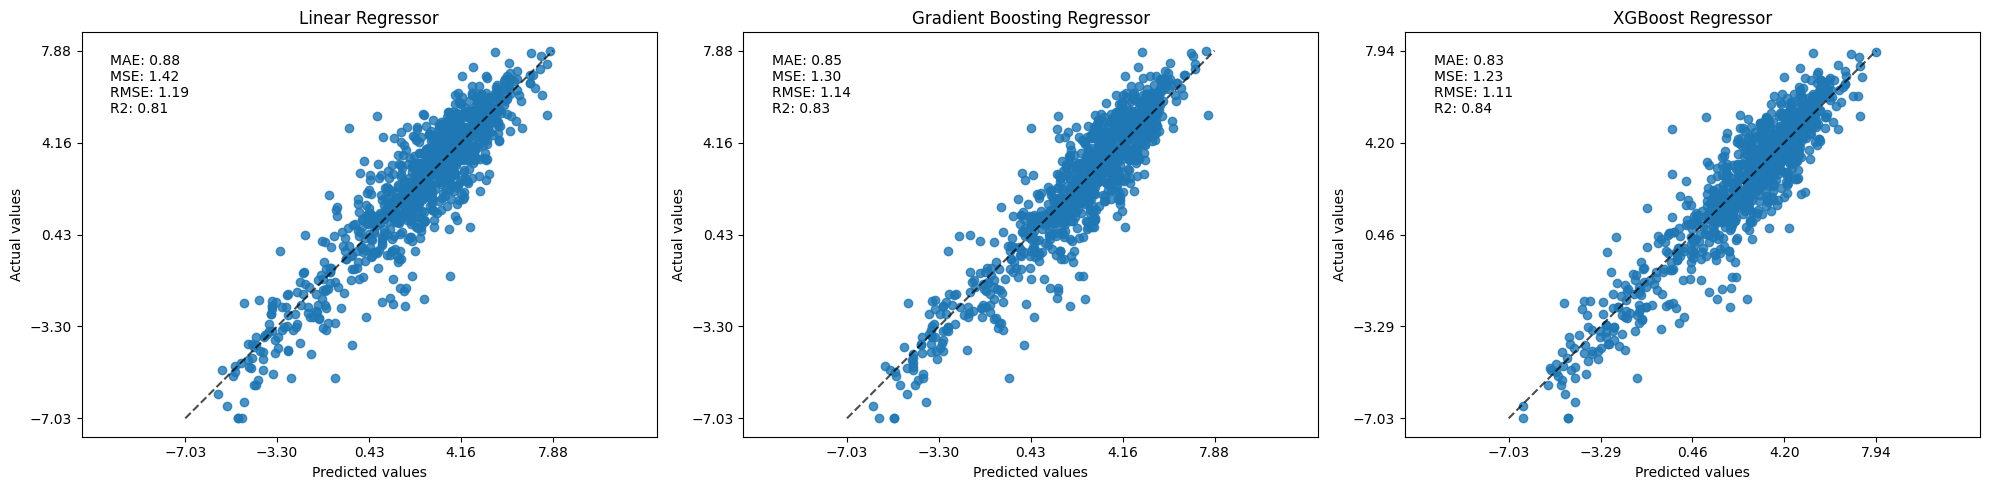

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Linear Regressor")
axs[0].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_lr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}\nR2: {r2_score(y_test, y_pred_lr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_gbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Gradient Boosting Regressor")
axs[1].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_gbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_gbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbr)):.2f}\nR2: {r2_score(y_test, y_pred_gbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_xgbr,
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[2],
    random_state=0,
)
axs[2].set_title("XGBoost Regressor")
axs[2].annotate(f"MAE: {mean_absolute_error(y_test, y_pred_xgbr):.2f}\nMSE: {mean_squared_error(y_test, y_pred_xgbr):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgbr)):.2f}\nR2: {r2_score(y_test, y_pred_xgbr):.2f}",
                xy=(0.05, 0.80),
                xycoords="axes fraction")

# fig.suptitle("")
plt.tight_layout()
plt.show()

## SHAP analysis

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[14:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


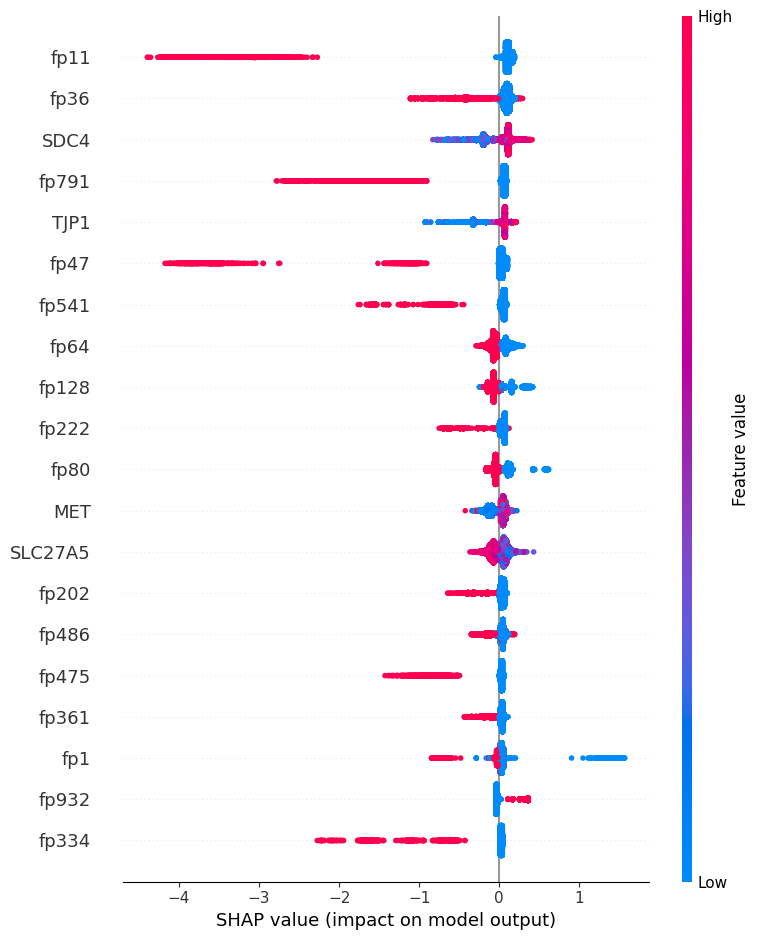

In [28]:

import shap
# SHAP analysis
explainer = shap.Explainer(xgbr_gpu)
shap_values = explainer.shap_values(x_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, x_test, feature_names=input_features)
